<a href="https://colab.research.google.com/github/phongvu009/NLP_Makemore_BatchNorm/blob/main/nlp_batch_norm_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [15]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-07-19 20:23:15--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2023-07-19 20:23:15 (11.9 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [16]:
words = open('names.txt', mode='r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [17]:
alphabet = sorted(list(set(''.join(words))))

#string to index dict
stoi = {char:idx+1 for idx,char in enumerate(alphabet)}
# add special character
stoi['.'] = 0

# index to string dict
itos = { idx:char for char,idx in  stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Build Dataset

In [18]:
import random

In [19]:
block_size =3

def build_dataset(words):
  X, Y = [],[]
  for word in words :
    # start with 0
    context = [0] * block_size
    for char in word + '.':
      #get index
      idx = stoi[char]
      X.append(context)
      Y.append(idx)
      #update context
      context = context[1:] + [idx]
  #transform the dataset to tensor
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

In [20]:
random.seed(42)
random.shuffle(words)
print(len(words))

n_1 = int(0.8 * len(words))
print(n_1)

n_2 = int(0.9 * len(words))
print(n_2)

32033
25626
28829


In [21]:
# Train dataset : 80%
X_train, Y_train = build_dataset(words[:n_1])

# Dev/Validation dataset: 10%
X_dev , Y_dev = build_dataset(words[n_1:n_2])

# Test dataset : 10%
X_test , Y_test = build_dataset(words[n_2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Pre-Train: Weight Initialization
- Using square root of fanin: https://pytorch.org/docs/stable/nn.init.html

In [22]:
vocab_size = len(itos) # all labels
n_embd = 10 #dimension of embedding
n_hidden = 200 # the number of neurons in hidden layer

In [23]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn( (vocab_size, n_embd), generator=g) # For embbeding layer (27,1) -> (27,10)

W1 = torch.randn( (n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size)**0.5
b1 = torch.randn( n_hidden, generator=g) * 0.01

W2 = torch.randn( (n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn( vocab_size, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones( (1,n_hidden))
bnbias = torch.zeros( (1,n_hidden))
bnmean_running = torch.zeros( (1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))


In [24]:
parameters = [C,W1,b1,W2,b2,bngain, bnbias]
print(sum(p.nelement() for p in parameters))

12297


In [25]:
#require gradient
for p in parameters:
  p.requires_grad = True

## Training

- Batch Norm :
  - In static, Standardization :  is to substract the mean and then dividing by its standard deviation. Make mean is 0 , std=1
  - In algebra, Normalizatin: Collapse inputs to be in a range. It can be -1,1 or 0,1
  - Bias b1 will be useseless. bnbias will be in charge
  - Momentum should be increase when batch_size increase

In [26]:
max_steps = 200000
batch_size = 32
lossi = []
stepi = []
momentum = 0.001
for i in range(max_steps):
  #create random mini-batch
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb,Yb = X_train[ix], Y_train[ix]
  #forward pass
  emb = C[Xb] # 32x3x10
  #flat data
  emb_flat = emb.view(emb.shape[0],-1) #32x30
  h_preact = emb_flat @ W1  #+ b1
  #-----------------------Apply BatchNorm----------------------
  h_preact_mean = h_preact.mean(0,keepdim=True)
  h_preact_std = h_preact.std(0,keepdim=True)
  h_std = ( h_preact - h_preact_mean ) / h_preact_std
  h_preact =  bngain *( h_std) + bnbias #unit gaussian for each neuron
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + momentum * h_preact_mean
    bnstd_running = 0.999 * bnstd_running + momentum * h_preact_std
  #-----------------------
  h = torch.tanh(h_preact) #output hidden layer: 32 x 100
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Yb)

  #backward pass
  for p in parameters: # reset gradients
    p.grad = None
  loss.backward()
  #update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0 : # watching loss
    print(f'{i:7d}/{max_steps:7d} ------ {loss.item():4f}')
  stepi.append(i)
  lossi.append(loss.log().item())

      0/ 200000 ------ 3.314689
  10000/ 200000 ------ 2.198443
  20000/ 200000 ------ 2.337455
  30000/ 200000 ------ 2.435885
  40000/ 200000 ------ 2.011928
  50000/ 200000 ------ 2.259472
  60000/ 200000 ------ 2.477500
  70000/ 200000 ------ 2.101999
  80000/ 200000 ------ 2.278812
  90000/ 200000 ------ 2.186207
 100000/ 200000 ------ 1.947383
 110000/ 200000 ------ 2.301028
 120000/ 200000 ------ 1.983655
 130000/ 200000 ------ 2.452322
 140000/ 200000 ------ 2.383932
 150000/ 200000 ------ 2.198680
 160000/ 200000 ------ 1.973299
 170000/ 200000 ------ 1.866808
 180000/ 200000 ------ 1.997269
 190000/ 200000 ------ 1.834683


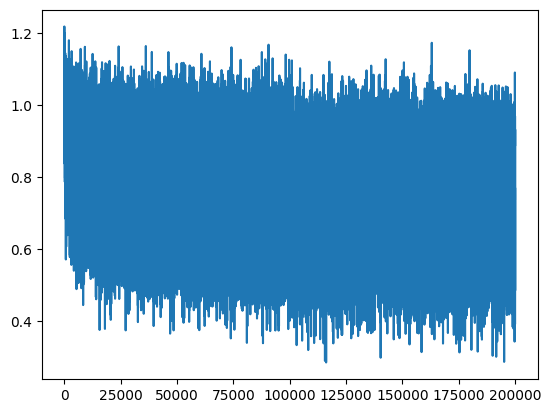

In [27]:
plt.plot(stepi,lossi)

## After Training Get Sample

 ### Calculate mean and std for entire the dataset:
- In training, the mean and std are calculated from batch
- To get sample after training, it will required calulating mean and std for entire dataset . After that, a sample can be put into the net work

In [32]:
with torch.no_grad():
  #pass the training set through:
  emb = C[X_train]
  emb_flat = emb.view( emb.shape[0], -1)
  h_preact = emb_flat @ W1 + b1
  #measure the mean/std over intire the training set
  bnmean = h_preact.mean(0, keepdim=True)
  bnstd = h_preact.std(0,keepdim=True)

In [33]:
@torch.no_grad()
def data_stage_loss(data_stage):
  x,y = {
      'train': (X_train, Y_train),
      'val' : (X_dev, Y_dev),
      'test' : (X_test, Y_test)
  }[data_stage]

  emb = C[x] #(N,block_size, n_embd)
  emb_flat = emb.view(emb.shape[0],-1)
  h_preact = emb_flat @ W1 + b1
  #Apply standardization
  h_preact_mean = h_preact.mean(0,keepdim=True)
  h_preact_std = h_preact.std(0,keepdim=True)
  h_std = ( h_preact - bnmean ) / bnstd
  h_preact =  bngain *( h_std) + bnbias #unit gaussian for each neuron
  h = torch.tanh(h_preact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y)
  print(data_stage, loss.item())



In [34]:
data_stage_loss('train')
data_stage_loss('val')

train 2.0668270587921143
val 2.1049270629882812
